# <font color = 'blue'> Project- Part A: Airbnb Price Prediction and Insights <font>

# Task 1: Data Exploration and Preprocessing


Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74111 entries, 0 to 74110
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      74111 non-null  int64  
 1   log_price               74111 non-null  float64
 2   property_type           74111 non-null  object 
 3   room_type               74111 non-null  object 
 4   amenities               74111 non-null  object 
 5   accommodates            74111 non-null  int64  
 6   bathrooms               73911 non-null  float64
 7   bed_type                74111 non-null  object 
 8   cancellation_policy     74111 non-null  object 
 9   cleaning_fee            74111 non-null  bool   
 10  city                    74111 non-null  object 
 11  description             74105 non-null  object 
 12  first_review            58247 non-null  object 
 13  host_has_profile_pic    73923 non-null  object 
 14  host_identity_verifi

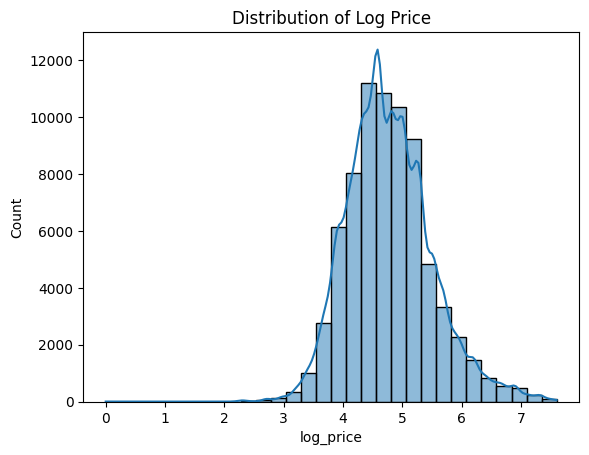

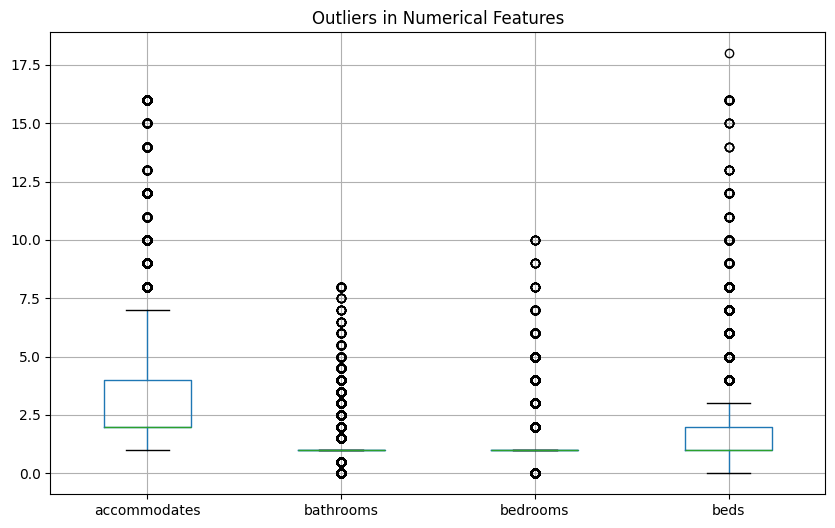

In [11]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings

warnings.filterwarnings('ignore')

# 1. Data Exploration and Preprocessing 
# 1.1 Load and Explore the Data
file_path = r"C:\Users\ayush\Downloads\Airbnb_data.xlsx"
data = pd.read_excel(file_path, sheet_name='airbnb_data')

print("Dataset Overview:")
print(data.info())
print("\nSummary Statistics:")
print(data.describe())

# Check for missing values
missing_values = data.isnull().sum()
print("\nMissing Values:")
print(missing_values)

# Visualize target variable
sns.histplot(data['log_price'], kde=True, bins=30)
plt.title('Distribution of Log Price')
plt.show()

# Boxplots to check for outliers in numerical features
numerical_features = ['accommodates', 'bathrooms', 'bedrooms', 'beds']
data[numerical_features].boxplot(figsize=(10, 6))
plt.title('Outliers in Numerical Features')
plt.show()

# 1.2 Handle Missing Values and Outliers
# Impute missing values
data['review_scores_rating'].fillna(data['review_scores_rating'].median(), inplace=True)
data.fillna({'bathrooms': 1.0, 'bedrooms': 1.0, 'beds': 1.0}, inplace=True)

# Drop unnecessary columns
data.drop(['id', 'name', 'thumbnail_url', 'zipcode', 'description'], axis=1, inplace=True)

In [12]:
# 2. Feature Engineering 
# Extract amenities count
data['amenities_count'] = data['amenities'].apply(lambda x: len(x.split(',')) if isinstance(x, str) else 0)
data.drop('amenities', axis=1, inplace=True)

# Convert boolean columns to integers
boolean_columns = ['cleaning_fee', 'instant_bookable', 'host_has_profile_pic', 'host_identity_verified']
data[boolean_columns] = data[boolean_columns].replace({'t': 1, 'f': 0}).fillna(0).astype(int)

# Drop date columns for simplicity
data.drop(['first_review', 'host_since', 'last_review'], axis=1, inplace=True)

# Separate categorical and numerical features
categorical_features = ['property_type', 'room_type', 'bed_type', 'cancellation_policy', 'neighbourhood']
numerical_features = ['accommodates', 'bathrooms', 'bedrooms', 'beds', 'number_of_reviews', 'review_scores_rating', 'amenities_count']

# Preprocessor pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

In [13]:
# 3. Model Development 
# Define features and target
X = data.drop(['log_price'], axis=1)
y = data['log_price']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the model pipeline with LightGBM
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LGBMRegressor(n_estimators=100, learning_rate=0.1, max_depth=10, random_state=42))
])

# Train the model
model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004043 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1128
[LightGBM] [Info] Number of data points in the train set: 59288, number of used features: 354
[LightGBM] [Info] Start training from score 4.780538
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['accommodates', 'bathrooms',
                                                   'bedrooms', 'beds',
                                                   'number_of_reviews',
                                                   'review_scores_rating',
                                                   'amenities_count']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['property_type', 'room_type',
                                                   'bed_type',
                                                   'cancellation_policy',
                                                   'neighbourhood'])])),
                ('regressor', LGBMRegressor(max_depth=10, random_state=42))])

In [14]:
# 4. Model Evaluation 
y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\nModel Performance:\n RMSE: {rmse}\n MAE: {mae}\n R²: {r2}")


Model Performance:
 RMSE: 0.4282626149805009
 MAE: 0.31588997797256185
 R²: 0.6429830228517117


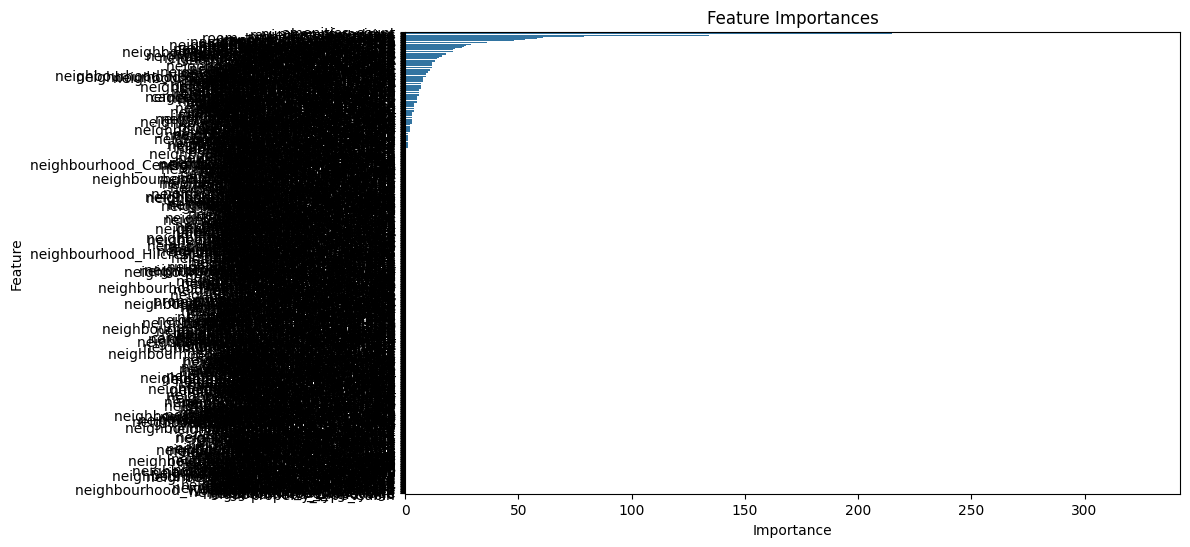


Findings:
- Model achieved an R² of 0.64 on the test data.
- Key features influencing the price include:
                Feature  Importance
6       amenities_count         326
4     number_of_reviews         308
0          accommodates         215
5  review_scores_rating         144
2              bedrooms         141


In [16]:
# 5. Visualization and Insights 
# Feature importance visualization
regressor = model.named_steps['regressor']
if hasattr(regressor, 'feature_importances_'):
    feature_names = numerical_features + list(preprocessor.transformers_[1][1].get_feature_names_out())
    importances = regressor.feature_importances_
    importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    importance_df.sort_values(by='Importance', ascending=False, inplace=True)

    plt.figure(figsize=(10, 6))
    sns.barplot(data=importance_df, x='Importance', y='Feature')
    plt.title('Feature Importances')
    plt.show()

# Deliverable Summary
print("\nFindings:")
print("- Model achieved an R² of {:.2f} on the test data.".format(r2))
print("- Key features influencing the price include:")
print(importance_df.head(5))

In [18]:
# Example of new listings data (ensure it's preprocessed in the same way as the training data)
new_listings = pd.DataFrame({
    'property_type': ['Apartment'],
    'room_type': ['Entire home/apt'],
    'accommodates': [4],
    'bathrooms': [1],
    'bed_type': ['Real Bed'],
    'cancellation_policy': ['Moderate'],
    'cleaning_fee': [1],  # Example: 1 (True)
    'city': ['New York'],
    'description': ['Beautiful apartment with great view.'],
    'host_has_profile_pic': [1],  # Example: 1 (True)
    'host_identity_verified': [1],  # Example: 1 (True)
    'host_response_rate': ['100%'],
    'instant_bookable': [1],  # Example: 1 (True)
    'latitude': [40.7128],
    'longitude': [-74.0060],
    'neighbourhood': ['Manhattan'],
    'number_of_reviews': [50],
    'review_scores_rating': [4.8],
    'zipcode': ['10001'],
    'amenities_count': [5],
    'bedrooms': [2],
    'beds': [2]
})

# Preprocess and predict the price for the new listing
new_listings_predictions = model.predict(new_listings)

# Print predicted price (in log scale)
print(f"Predicted Log Price for New Listing: {new_listings_predictions[0]}")

# Convert the log price to actual price (since we used log transformation during training)
predicted_price = np.exp(new_listings_predictions[0])  # Inverse of log transformation
print(f"Predicted Price for New Listing: ${predicted_price:.2f}")


Predicted Log Price for New Listing: 4.998691942158938
Predicted Price for New Listing: $148.22


# Video Link: https://drive.google.com/file/d/109memF8Y18PrErtSXCuoKg0xfioTcnll/view?usp=sharing

# <font color= 'blue'> Part B: Customer Churn Prediction <font>

# Task 1:Data Exploration and Preprocessing

In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# Step 1: Load the dataset
file_path = r"C:\Users\ayush\Downloads\Customer_data.xlsx"  # Update the file path as needed
data = pd.read_excel(file_path)

# Step 2: Explore the dataset
print("Dataset Overview:")
print(data.info())
print(data.describe())
print("Missing Values:\n", data.isnull().sum())

# Step 3: Handle missing values
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')
data['TotalCharges']=data['TotalCharges'].fillna(data['TotalCharges'].median())

# Step 4: Encode categorical variables
data_encoded = pd.get_dummies(data, drop_first=True)

# Step 5: Scale numerical features
scaler = StandardScaler()
numerical_features = ['MonthlyCharges', 'TotalCharges', 'tenure']
data_encoded[numerical_features] = scaler.fit_transform(data_encoded[numerical_features])

# Display processed data
print("Processed Data:\n", data_encoded.head())


Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 n

# Task 2: Machine Learning Model

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Step 6: Define features (X) and target (y)
X = data_encoded.drop(columns=['Churn_Yes'])  # Replace 'Churn_Yes' with the actual encoded target column
y = data_encoded['Churn_Yes']

# Step 7: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 8: Train a classification model (Random Forest)
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

# Task 3: Model Evaluation

Accuracy: 0.80
Precision: 0.67
Recall: 0.45
F1 Score: 0.54
ROC AUC: 0.69
Confusion Matrix:
 [[954  82]
 [204 169]]


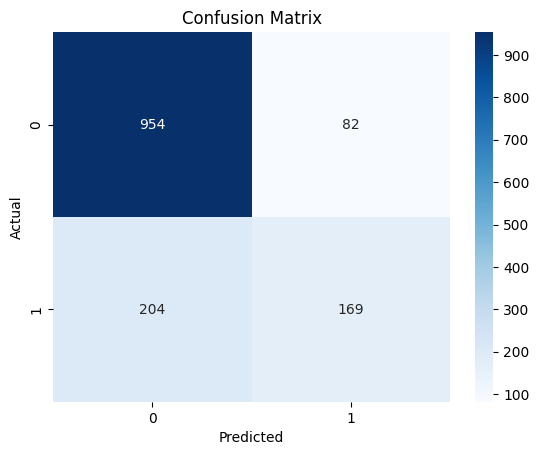

In [5]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score

# Step 9: Predict on the test set
y_pred = model.predict(X_test)

# Step 10: Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"ROC AUC: {roc_auc:.2f}")
print("Confusion Matrix:\n", conf_matrix)

# Visualize the Confusion Matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


# Task 4: Predictions for New Data and Insights

4a: Predictions for New Data

In [10]:
# Example: Sample new customer data
sample_new_data = {
    'tenure': 12,  # 12 months
    'MonthlyCharges': 70.0,
    'TotalCharges': 840.0,
    'gender_Male': 1,
    'SeniorCitizen_1': 0,
    'Partner_Yes': 1,
    'Dependents_Yes': 0,
    'PhoneService_Yes': 1,
    'MultipleLines_Yes': 0,
    'InternetService_Fiber optic': 1,
    'OnlineSecurity_Yes': 0,
    'TechSupport_Yes': 1,
    'StreamingTV_Yes': 0,
    'StreamingMovies_Yes': 1,
    'Contract_One year': 1,
    'PaperlessBilling_Yes': 1,
    'PaymentMethod_Electronic check': 0
}

# Convert the sample data into a DataFrame
sample_new_data_df = pd.DataFrame([sample_new_data])

# Ensure the new data has the same columns as the training data (handle missing columns)
missing_cols = list(set(X.columns) - set(sample_new_data_df.columns))

# Add all missing columns at once using pd.concat
missing_data = pd.DataFrame(0, index=sample_new_data_df.index, columns=missing_cols)
sample_new_data_df = pd.concat([sample_new_data_df, missing_data], axis=1)

# Reorder the columns to match the training data (X.columns)
sample_new_data_df = sample_new_data_df[X.columns]

# Scale the numerical features for the new data
sample_new_data_df[numerical_features] = scaler.transform(sample_new_data_df[numerical_features])

# Make predictions
sample_new_prediction = model.predict(sample_new_data_df)  # Predicted labels (0 or 1)
sample_new_probability = model.predict_proba(sample_new_data_df)[:, 1]  # Predicted probabilities of churn

# Add predictions to the new data
sample_new_data_df['Predicted_Churn'] = sample_new_prediction
sample_new_data_df['Churn_Probability'] = sample_new_probability

# Display the results
print(f"Predicted Churn: {sample_new_prediction[0]}")
print(f"Churn Probability: {sample_new_probability[0]:.2f}")


Predicted Churn: False
Churn Probability: 0.32


4b: Insights and Recommendations

Insights and Recommendations

Insights
- Customers with short tenure and high monthly charges are more likely to churn.
- Lack of additional services (e.g., OnlineSecurity, TechSupport) correlates with churn.

Recommendations
1. Offer discounts to customers with high churn probabilities.
2. Improve customer support and engagement strategies.
3. Promote bundled services to reduce churn.


# Video Link : https://drive.google.com/file/d/1fIYG74DAGxhQR9ZckLyE5Nw7eKf9imYv/view?usp=sharing